In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import bocd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import yfinance as yf

from machine_learning_finance import (analyze_trades, 
    plot_backtest_analysis, RangeTrainingWindowUtil,
    metrics_to_dataframe, TraderEnv, make_price_marker_from_boolean, add_marker, add_line,
    plot_backtest_differences)

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta

init_notebook_mode(connected=True)
windows = [300, 600, 900, 1500]

symbol = "SPY"
file = f"../backtests/{symbol}-model-back-test.csv"
diffs = f"../backtests/{symbol}-model-differences.csv"
period = 365
pd.options.display.max_rows = None
inverse = None # set to anything to graph inverse longs

def plot_win_loss(file, metrics):
    ledger = pd.read_csv(file)
    # Set the style for the plots
    sns.set(style='whitegrid')

    # Create a bar plot for profit and loss stats
    profit_stats, loss_stats = metrics['profit_stats'], metrics['loss_stats']
    profit_loss_df = pd.DataFrame([profit_stats, loss_stats], columns=['min', 'max', 'mean', 'median', 'std'], index=['profit', 'loss'])

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=profit_loss_df.transpose(), palette='muted')
    ax.set_title('Profit and Loss Statistics')
    ax.set_ylabel('Value')

    # Show the plot
    plt.show()

def analyze_and_graph_backtest(file, symbol, df, sentiment_diff = False):
    ledger = pd.read_csv(file)
    ledger["Date"] = pd.to_datetime(ledger['Date'])
    return analyze_and_graph_range(file, symbol, ledger["Date"].min(), ledger["Date"].max(), df, ledger, sentiment_diff)
        
def analyze_and_graph_tail(file, symbol, df, days=365):
    now = datetime.now()
    start = now - timedelta(days=days)
    start = start.strftime('%Y-%m-%d')
    end = now.strftime('%Y-%m-%d')
    return analyze_and_graph_range(file, symbol, start, end, df)

def analyze_differences(file):
    df = pd.read_csv(file)
    df["Date"] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    fig = plot_backtest_differences(df)
    fig.update_layout(title='Differences Analysis', xaxis_title='Date', height=800)
    fig.show()
    return fig, df


def analyze_and_graph_range(file, symbol, start, end, df, ledger=None, sentiment_diff=False):
    if ledger is None:
        ledger = pd.read_csv(file)
    training_window = RangeTrainingWindowUtil(df, start, end)
    env = TraderEnv(symbol, training_window.test_df, training_window.full_hist_df)

    fig = plot_backtest_analysis(env.visualization_timeseries, ledger, inverse=inverse)

    # convert each change point column to price of the average in question
    analytics_df = env.visualization_timeseries
    periods=[30, 60, 90]
    colors=["blue", "purple", "green"]
    for period, color in zip(periods, colors):        
        marker_col =  f"cp-loc-{period}"
        trend_col = f"trend-{period}"
        analytics_df = make_price_marker_from_boolean(analytics_df, f"change-point-{period}", f"trend-{period}", marker_col) 
        add_marker(fig, analytics_df, marker_col, f"change-point-{period}", "diamond", 8, color)
        add_line(fig, analytics_df, trend_col, f"moving-avg-{period}", color)

    analytics_df["expert"] = env.expert_actions
    analytics_df["expert_buy"] =  np.where(analytics_df["expert"] == 0, analytics_df["Close"], np.nan)
    analytics_df["expert_sell"] =  np.where(analytics_df["expert"] == 1, analytics_df["Close"], np.nan)
    add_marker(fig, analytics_df, "expert_buy", "expert_buy", "triangle-up", 8, "springgreen")
    add_marker(fig, analytics_df, "expert_sell", "expert_sell", "triangle-down", 8, "purple")

    fig.update_layout(title='Backtest Analysis', xaxis_title='Date', height=800)
    fig.show()

    
    fig = make_subplots(rows=3, cols=1)
    indexes=[1,2,3]
    for period, color, index in zip(periods, colors, indexes):        
        fig.add_trace(go.Bar(x=analytics_df.index, y=analytics_df[f'polynomial_derivative-{period}'], marker=dict(color=f'{color}', colorscale='Viridis'), name=f'Polynomial Derivative {period}'), row=index, col=1)

    fig.update_layout(title='Backtest Analysis', xaxis_title='Date', height=800)
    fig.show()

    return ledger, training_window.test_df, env, analytics_df

ticker_obj = yf.download(tickers=symbol)
df = pd.DataFrame(ticker_obj)
ledger, df2, env, analytics_df = analyze_and_graph_backtest(file, symbol, df)

fig, df = analyze_differences(diffs)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[*********************100%***********************]  1 of 1 completed
Initializing info for: SPY


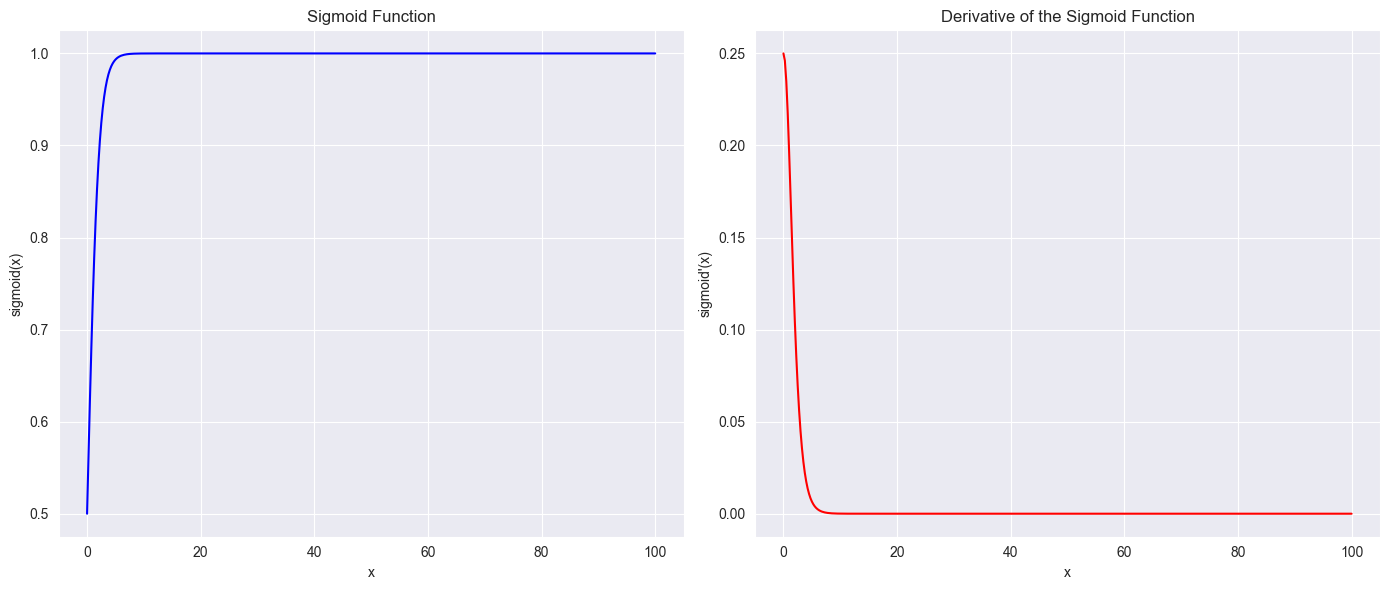

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the sigmoid function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Generate an array of values
x_values = np.linspace(0, 100, 400)
y_values = sigmoid(x_values)
y_values_derivative = sigmoid_derivative(sigmoid(x_values))  # Apply the derivative on the sigmoid output

# Create the plot
plt.figure(figsize=(14, 6))

# Plot sigmoid function
plt.subplot(1, 2, 1)
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid(True)
plt.plot(x_values, y_values, label='sigmoid(x)', color='b')

# Plot derivative of the sigmoid function
plt.subplot(1, 2, 2)
plt.title('Derivative of the Sigmoid Function')
plt.xlabel('x')
plt.ylabel("sigmoid'(x)")
plt.grid(True)
plt.plot(x_values, y_values_derivative, label="sigmoid'(x)", color='r')

# Show the plot
plt.tight_layout()
plt.show()

